In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pandas.plotting import scatter_matrix

# Guide 

- For data visualization see the file `data_visualization.ipynb`
- The preprocessing is done in the file `preprocessing.ipynb`
- The benchmark model is in the file `benchmark.ipynb`

# Regression

In [38]:
%load_ext autoreload
%autoreload 2

import math  # for sqrt
from statistics import mean

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
from andrea_models import AndreaLinearRegression  # In the course library
from dataset import get_dataset
from preprocessing import preprocessData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:



df_train, df_test = preprocessData(*get_dataset())
target = 't0s0'

all_cols = df_train.columns.tolist()
all_features = all_cols.copy()
all_features.remove(target)

all_features_model = AndreaLinearRegression()
all_features_model.fit(df_train.drop(columns=[target]), df_train[target], column_names=all_features)
all_features_model.summary()

prediction = all_features_model.predict(df_test[all_features])

RMSE_all_features = math.sqrt(mean_squared_error(df_test[target], prediction))
print('='*50)
print('RMSE now: ', RMSE_all_features)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                 1.843e+04
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:24:05   Log-Likelihood:                 40909.
No. Observations:               31119   AIC:                        -8.180e+04
Df Residuals:                   31109   BIC:                        -8.171e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

The RMSE is relatively high, maybe this is happening because there are hight correlated features.

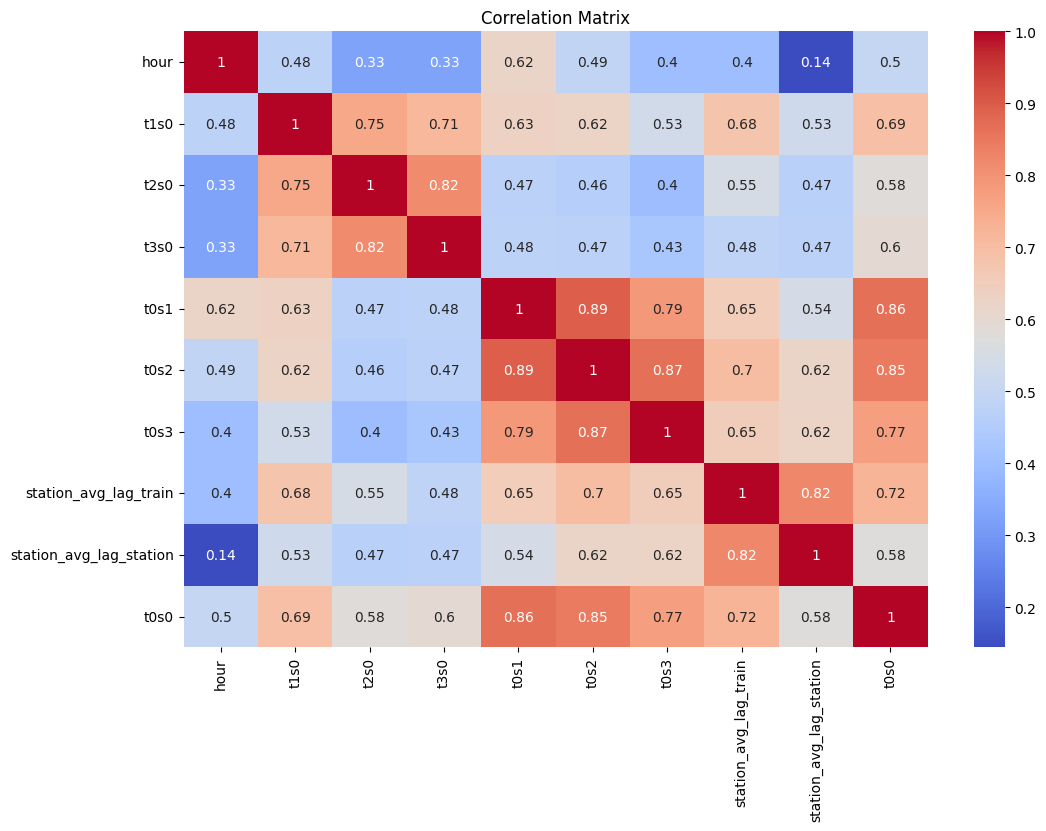

In [40]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[all_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from tqdm.notebook import tqdm

# Lets make a grid search to find the best features to drop
# Try all combinations of features
import itertools
import heapq

all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = AndreaLinearRegression()
    model.fit(df_train[list(comb)], df_train[target], column_names=list(comb))
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour',), RMSE: 0.31512871300761036
Combination: ('t2s0',), RMSE: 0.32398511088639764
Combination: ('t3s0',), RMSE: 0.3246727194338522
Combination: ('t2s0', 't3s0'), RMSE: 0.32614860488353475
Combination: ('hour', 't2s0'), RMSE: 0.327092847387077
Combination: ('hour', 't3s0'), RMSE: 0.3277675116685246
Combination: ('hour', 't2s0', 't3s0'), RMSE: 0.32876679108532925
Combination: ('t1s0',), RMSE: 0.32934568938695225
Combination: ('station_avg_lag_station',), RMSE: 0.3294663662828442
Combination: ('hour', 't1s0'), RMSE: 0.3299886509012867


# Polinomial regression

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [56]:
parameters_to_test = {'polynomialfeatures__degree': np.arange(1, 5)}
k_fold = KFold(n_splits=5, shuffle=True, random_state=6)


def MyPolynomialRegression(degree=2, include_bias=False):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=include_bias),
                         AndreaLinearRegression())


grid = GridSearchCV(MyPolynomialRegression(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error')


grid.fit(df_train[all_features], df_train[target])

GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('andrealinearregression',
                                        AndreaLinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([1, 2, 3, 4])},
             scoring='neg_mean_squared_error')

In [58]:
print('Best parameters:', grid.best_params_)
print('Best score:', math.sqrt(mean(-grid.cv_results_['mean_test_score'])))

model = grid.best_estimator_

model.fit(df_train[all_features], df_train[target])
prediction = model.predict(df_test[all_features])

print("RMSE: ", np.sqrt(mean_squared_error(df_test[target], prediction)))

Best parameters: {'polynomialfeatures__degree': 4}
Best score: 0.03990889841352994
RMSE:  0.40009681745445547


In [ ]:
all_combinations = []
for i in range(1, 5):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=3),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour',), RMSE: 0.3197070890035743
Combination: ('t2s0',), RMSE: 0.3266187960996996
Combination: ('t1s0',), RMSE: 0.33041349511556606
Combination: ('station_avg_lag_station',), RMSE: 0.33137163608068837
Combination: ('hour', 't2s0'), RMSE: 0.3314485902549274
Combination: ('t3s0',), RMSE: 0.33173432774103534
Combination: ('t1s0', 't2s0'), RMSE: 0.3323940977576226
Combination: ('hour', 't1s0'), RMSE: 0.3336216614764021
Combination: ('t0s3',), RMSE: 0.33371214012119127
Combination: ('t2s0', 't3s0'), RMSE: 0.3338841754578807


In [61]:
all_combinations = []
for i in range(1, 5):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=2),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour',), RMSE: 0.3152789211102112
Combination: ('t2s0',), RMSE: 0.3263130742644089
Combination: ('t3s0',), RMSE: 0.3296572344855124
Combination: ('station_avg_lag_station',), RMSE: 0.33071841740712826
Combination: ('t1s0',), RMSE: 0.3307285974694034
Combination: ('hour', 't2s0'), RMSE: 0.3311455936832919
Combination: ('t1s0', 't2s0'), RMSE: 0.331293137962037
Combination: ('t2s0', 't3s0'), RMSE: 0.3313527148991667
Combination: ('hour', 't1s0'), RMSE: 0.3323020610615509
Combination: ('t0s3',), RMSE: 0.3335840821588979


In [64]:
all_combinations = []
for i in range(1, 5):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=4),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/255 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('hour',), RMSE: 0.3198335678484843
Combination: ('t2s0',), RMSE: 0.32679929251585993
Combination: ('station_avg_lag_station',), RMSE: 0.3301387964829412
Combination: ('t1s0',), RMSE: 0.33060470998701164
Combination: ('hour', 't2s0'), RMSE: 0.331814753641116
Combination: ('t3s0',), RMSE: 0.3321836809747182
Combination: ('t1s0', 't2s0'), RMSE: 0.3324762271268633
Combination: ('t0s3',), RMSE: 0.3338979796405802
Combination: ('hour', 't1s0'), RMSE: 0.33427336829060633
Combination: ('t2s0', 'station_avg_lag_station'), RMSE: 0.3344165869510843


# Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200, random_state=42, criterion='squared_error')

# Fit the model
rf_model.fit(df_train[all_features], df_train[target])

# Predict on the test set
prediction = rf_model.predict(df_test[all_features])

# Calculate RMSE
RMSE_rf = np.sqrt(mean_squared_error(df_test[target], prediction))
print('RMSE Random Forest:', RMSE_rf)

RMSE Random Forest: 0.3537053377310392


In [67]:
# Define the columns to use
cols = ['hour','t1s0', 't2s0', 't3s0', 'station_avg_lag_station']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200, random_state=42, criterion='squared_error')

# Fit the model
rf_model.fit(df_train[cols], df_train['t0s0'])

# Predict on the test set
prediction = rf_model.predict(df_test[cols])

# Calculate RMSE
RMSE_rf = np.sqrt(mean_squared_error(df_test['t0s0'], prediction))
print('RMSE Random Forest:', RMSE_rf)

RMSE Random Forest: 0.3480927972406533


# Neural Network

In [ ]:
# !pip install tensorflow

In [68]:
print(df_train.shape)

(31119, 10)


In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
import matplotlib.pyplot as plt

# Define the neural network model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, input_dim=input_dim, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error', metrics=['mse'])
    return model

# Create the model
model = create_model(input_dim=df_train[cols].shape[1])

# Train the model and store the training history
history = model.fit(df_train[cols], df_train['t0s0'], epochs=100,
                    batch_size=32, validation_data=(df_test[cols], df_test['t0s0']))

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/home/arthur/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-17 22:04:24.003160: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_NO_BINARY_FOR_GPU'

2024-12-17 22:04:24.003215: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2024-12-17 22:04:24.003234: W tensorflow/core/framework/op_kernel.cc:1829] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2024-12-17 22:04:24.003250: 

InternalError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Cast] name: 

In [46]:
# Calculate RMSE
y_pred = model.predict(X_test)
RMSE_nn = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE Neural Network:', RMSE_nn)

247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
RMSE Neural Network: 0.3706456680608082


# autogluon

In [3]:
#! pip install autogluon
from autogluon.tabular import TabularPredictor

x_train = pd.read_csv('./Xtrain.csv')
y_train = pd.read_csv('./Ytrain.csv')

x_test = pd.read_csv('./Xtest.csv')
y_sample = pd.read_csv('./Ysample.csv')

# Add t0s0 
x_train['t0s0'] = y_train['t0s0']
x_test['t0s0'] = y_sample['t0s0']

In [ ]:
predictor = TabularPredictor(label='t0s0').fit(train_data=x_train)
predictions = predictor.predict(x_test)

In [130]:
predictor = TabularPredictor.load("/media/arthur/HD/Users/arthu/projetos/machine-learning-for-networks/project/AutogluonModels/ag-20241211_012310")

predictor.evaluate(x_test)

{'root_mean_squared_error': -0.4197631785901537,
 'mean_squared_error': -0.1762011261001093,
 'mean_absolute_error': -0.3428852462157734,
 'r2': -1.1380229801971264,
 'pearsonr': -0.00034718306570084324,
 'median_absolute_error': -0.3042307014465332}

In [131]:
predictor.leaderboard(x_test)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,-0.402479,-0.065125,root_mean_squared_error,0.088340,0.026568,0.053639,0.088340,0.026568,0.053639,1,True,2
1,KNeighborsUnif,-0.402479,-0.083411,root_mean_squared_error,0.091594,0.026319,0.054304,0.091594,0.026319,0.054304,1,True,1
2,NeuralNetTorch,-0.413552,-0.022988,root_mean_squared_error,0.050451,0.015437,49.946575,0.050451,0.015437,49.946575,1,True,10
3,LightGBMXT,-0.419352,-0.015647,root_mean_squared_error,3.566449,0.697394,12.843390,3.566449,0.697394,12.843390,1,True,3
4,CatBoost,-0.419583,-0.015766,root_mean_squared_error,0.062144,0.008797,118.303798,0.062144,0.008797,118.303798,1,True,6
5,WeightedEnsemble_L2,-0.419763,-0.014675,root_mean_squared_error,5.353852,1.015203,194.265181,0.008684,0.000551,0.020796,2,True,12
6,LightGBM,-0.419978,-0.015889,root_mean_squared_error,0.726526,0.121344,5.247526,0.726526,0.121344,5.247526,1,True,4
7,XGBoost,-0.420019,-0.015648,root_mean_squared_error,0.319945,0.063056,6.720041,0.319945,0.063056,6.720041,1,True,9
8,ExtraTreesMSE,-0.420068,-0.016698,root_mean_squared_error,0.356590,0.100216,6.961895,0.356590,0.100216,6.961895,1,True,7
9,LightGBMLarge,-0.420126,-0.016041,root_mean_squared_error,0.919892,0.134956,9.404408,0.919892,0.134956,9.404408,1,True,11


In [9]:
df_test_preprocessed = preprocess_data(x_test, y_sample)
df_train_preprocessed = preprocess_data(x_train, y_train)

In [12]:
predictor = TabularPredictor(label='t0s0').fit(train_data=df_train_preprocessed)
predictions = predictor.predict(df_test_preprocessed)

No path specified. Models will be saved in: "AutogluonModels/ag-20241211_161227"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
CPU Count:          8
Memory Avail:       13.63 GB / 19.41 GB (70.2%)
Disk Space Avail:   835.31 GB / 930.26 GB (89.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in

[1000]	valid_set's rmse: 0.0165453
[2000]	valid_set's rmse: 0.0160131
[3000]	valid_set's rmse: 0.0158562
[4000]	valid_set's rmse: 0.0158162
[5000]	valid_set's rmse: 0.0158107
[6000]	valid_set's rmse: 0.0158042
[7000]	valid_set's rmse: 0.0157878
[8000]	valid_set's rmse: 0.0158066
[9000]	valid_set's rmse: 0.0158058


	-0.0158	 = Validation score   (-root_mean_squared_error)
	12.94s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0159907
[2000]	valid_set's rmse: 0.0157882


	-0.0158	 = Validation score   (-root_mean_squared_error)
	4.73s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0163	 = Validation score   (-root_mean_squared_error)
	31.79s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0154	 = Validation score   (-root_mean_squared_error)
	79.98s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.016	 = Validation score   (-root_mean_squared_error)
	15.31s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0163	 = Validation score   (-root_mean_squared_error)
	53.92s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0155	 = Validation score   (-root_mean_squared_error)
	8.95s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.0191	 = Validation score   (-root_mean_squared_error)
	55.73s	 = Training   runtime
	0.02s	 = Validation ru

[1000]	valid_set's rmse: 0.0157198


	-0.0157	 = Validation score   (-root_mean_squared_error)
	7.5s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'CatBoost': 0.263, 'NeuralNetFastAI': 0.263, 'XGBoost': 0.263, 'RandomForestMSE': 0.158, 'ExtraTreesMSE': 0.053}
	-0.0146	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 275.2s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 6753.8 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/media/arthur/HD/Users/arthu/projetos/machine-learning-for-networks/project/AutogluonModels/ag-20241211_161227")


In [13]:
predictor.leaderboard(df_test_preprocessed)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsUnif,-0.411658,-0.078444,root_mean_squared_error,0.132601,0.024563,0.062893,0.132601,0.024563,0.062893,1,True,1
1,KNeighborsDist,-0.411716,-0.063068,root_mean_squared_error,0.151916,0.014981,0.045250,0.151916,0.014981,0.045250,1,True,2
2,NeuralNetTorch,-0.417389,-0.019074,root_mean_squared_error,0.050180,0.015383,55.732796,0.050180,0.015383,55.732796,1,True,10
3,NeuralNetFastAI,-0.419894,-0.016251,root_mean_squared_error,0.269404,0.074030,53.918774,0.269404,0.074030,53.918774,1,True,8
4,ExtraTreesMSE,-0.420121,-0.015953,root_mean_squared_error,0.634571,0.100582,15.307039,0.634571,0.100582,15.307039,1,True,7
5,RandomForestMSE,-0.420380,-0.016335,root_mean_squared_error,0.821058,0.103388,31.786883,0.821058,0.103388,31.786883,1,True,5
6,WeightedEnsemble_L2,-0.420453,-0.014583,root_mean_squared_error,2.209878,0.370160,189.965324,0.007508,0.000606,0.021135,2,True,12
7,LightGBMXT,-0.420477,-0.015787,root_mean_squared_error,3.413312,0.675828,12.935828,3.413312,0.675828,12.935828,1,True,3
8,LightGBM,-0.420766,-0.015782,root_mean_squared_error,0.522667,0.109172,4.732346,0.522667,0.109172,4.732346,1,True,4
9,CatBoost,-0.420803,-0.015354,root_mean_squared_error,0.063236,0.010286,79.977634,0.063236,0.010286,79.977634,1,True,6
